In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from scipy.stats import ttest_ind
import warnings; warnings.simplefilter('ignore')

In [3]:
def add_data(df):
    """ Заполение пропусков.

    На вход подаётся датафрейм с пропущенными значениями.
    В ходе выполнения формируется список признаков, содержащих пропущенные данные.
    Пропуски заполняются в зависимости от типа данных, в данном случае находится мода
    колонки датафрейма.
    Функция возвращает датафрейм с заполненными пропусками.
    
    """
    cols_with_missing = [col for col in df.columns if df[col].isnull().sum()>0]
    for col in cols_with_missing:
        if df[col].dtypes == 'object':
            plus_data[col] = df[col].fillna(df[col].mode()[0])
        if df[col].dtypes.str.find('int' or 'float'):
            plus_data[col] = df[col].fillna(df[col].mode()[0])
    return plus_data


def code_data(df):
    """ Кодирование категориального признака.

    На вход подаётся датафрейм.
    В ходе выполнения формируется список признаков с типом данных object и, содержащих два значения.
    Первому присваивается значение 0, второму 1. В результате выполнения формулы к указанному датафрейму
    будут добавлены новые столбцы с именем название колонки + '_code'.
    Для столбцов, содержащих больше двух значений, применяется метод get_dummies, с целью их разделения
    на несколько колонок, которые будут содержать значения 0 и 1.
    Функция возвращает датафрейм, содержащий кодированные данные.
    
    """
    get_code = [col for col in df.columns if (df[col].nunique() > 2) & (df[col].dtype == object)]
    for col in get_code:
        data_code = pd.get_dummies(df, columns = [col])
        
    column_code = [col for col in df.columns if (df[col].nunique() == 2) & (df[col].dtype == object)]
    for col in column_code:
        data_code[col + '_code'] = np.where(df[col].str.contains(np.sort(df[col].unique())[0]), 0, 1)
        data_code.drop(col, axis = 1, inplace = True)
    return data_code


def get_boxplot(column):
    """Построение box-plot графиков распределения номинативных переменных относительно целевой переменной.
    
    На вход подаются столбцы, для которых должно быть построено распределение. По оси x - столбец,
    по оси y - целевая переменная.
    
    """
    fig, ax = plt.subplots(figsize=(14, 4))
    sns.boxplot(x=column, y='score',
                data=plus_data,
                ax=ax)
    plt.xticks(rotation=45)
    ax.set_title('Boxplot for ' + column)
    plt.show()

    
def get_stat_dif(column):
    """Определение наличия статистически значимых различий между парами столбец - целевой столбец
    с помощью теста Стьюдента.
    
    На вход подаются столбцы и формируется список пар комбинаций столбец - целевой столбец,
    после чего проводится тест Стьюдента с учётом поправки Бонферони.
    
    """
    cols = plus_data.loc[:, column].value_counts().index[:]
    combinations_all = list(combinations(cols, 2))
    for comb in combinations_all:
        if ttest_ind(plus_data.loc[plus_data.loc[:, column] == comb[0], 'score'],
                     plus_data.loc[plus_data.loc[:, column] == comb[1], 'score']).pvalue \
                <= 0.1/len(combinations_all):  # Учли поправку Бонферони
            print('Найдены статистически значимые различия для колонки', column)
            break

Первичный осмотр данных

In [4]:
pd.set_option('display.max_rows', 50) # показывать больше строк
pd.set_option('display.max_columns', 50) # показывать больше колонок

progress = pd.read_csv('stud_math.csv')

Рассмотрим, какие данные хранятся в файле и какие типы данных у столбцов:

In [5]:
display(progress.head(5))
progress.info()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,"studytime, granular",higher,internet,romantic,famrel,freetime,goout,health,absences,score
0,GP,F,18,U,NaN,A,4.0,4.0,at_home,teacher,course,mother,2.0,2.0,0.0,yes,no,no,no,yes,-6.0,yes,NaN,no,4.0,3.0,4.0,3.0,6.0,30.0
1,GP,F,17,U,GT3,NaN,1.0,1.0,at_home,other,course,father,1.0,2.0,0.0,no,yes,no,no,no,-6.0,yes,yes,no,5.0,3.0,3.0,3.0,4.0,30.0
2,GP,F,15,U,LE3,T,1.0,1.0,at_home,other,other,mother,1.0,2.0,3.0,yes,no,NaN,no,yes,-6.0,yes,yes,NaN,4.0,3.0,2.0,3.0,10.0,50.0
3,GP,F,15,U,GT3,T,4.0,2.0,health,NaN,home,mother,1.0,3.0,0.0,no,yes,yes,yes,yes,-9.0,yes,yes,yes,3.0,2.0,2.0,5.0,2.0,75.0
4,GP,F,16,U,GT3,T,3.0,3.0,other,other,home,father,1.0,2.0,0.0,no,yes,yes,no,yes,-6.0,yes,no,no,4.0,3.0,2.0,5.0,4.0,50.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   school               395 non-null    object 
 1   sex                  395 non-null    object 
 2   age                  395 non-null    int64  
 3   address              378 non-null    object 
 4   famsize              368 non-null    object 
 5   Pstatus              350 non-null    object 
 6   Medu                 392 non-null    float64
 7   Fedu                 371 non-null    float64
 8   Mjob                 376 non-null    object 
 9   Fjob                 359 non-null    object 
 10  reason               378 non-null    object 
 11  guardian             364 non-null    object 
 12  traveltime           367 non-null    float64
 13  studytime            388 non-null    float64
 14  failures             373 non-null    float64
 15  schoolsup            386 non-null    obj

Выведем общее количество строк и столбцов

In [6]:
progress.shape

(395, 30)

Первичный анализ данных в столбцах

Для удобства использования pandas переименуем все столбцы:

In [7]:
progress.columns

Index(['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu',
       'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime',
       'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery',
       'studytime, granular', 'higher', 'internet', 'romantic', 'famrel',
       'freetime', 'goout', 'health', 'absences', 'score'],
      dtype='object')

In [8]:
progress.columns = ['school', 'sex', 'age', 'address', 'famsize', 'pstatus', 'medu', 'fedu',
       'mjob', 'fjob', 'reason', 'guardian', 'traveltime', 'studytime',
       'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery',
       'studytime_granular', 'higher', 'internet', 'romantic', 'famrel',
       'freetime', 'goout', 'health', 'absences', 'score']

Выведем все колонки, в которых пропущены данные и количество пропусков.

In [9]:
null_data = progress.isnull().sum()
null_data[null_data > 0]

address               17
famsize               27
pstatus               45
medu                   3
fedu                  24
mjob                  19
fjob                  36
reason                17
guardian              31
traveltime            28
studytime              7
failures              22
schoolsup              9
famsup                39
paid                  40
activities            14
nursery               16
studytime_granular     7
higher                20
internet              34
romantic              31
famrel                27
freetime              11
goout                  8
health                15
absences              12
score                  6
dtype: int64

Максимальное количество пропусков содержится в колонке **pstatus** - 45.
Оценим процентное соотношение количества пропусков к общему числу строк:

In [10]:
progress.pstatus.isnull().sum() / progress.shape[0] * 100

11.39240506329114

Как можно видеть количество пропусков меньше 12%, что не даёт достаточных оснований для удаления этого и какого-либо другого столбца.

Параметр **score** является целевым для создания модели, поэтому должен содержать только достоверные данные. По этой причине удаляем строки с пропусками в этой колонке.

In [11]:
rate = progress.copy()
rate = rate[~rate.score.isnull()]

Проверим, что этих строк больше нет:

In [12]:
null_data = rate.isnull().sum()
null_data['score']

0

Рассморим распределение данных с типом object
Для удобства сохраним их в отдельный датафрейм
Также создадим список, в который будем записывать имена параметров, неподходящих для будущей модели.

In [13]:
rate_obj = rate.select_dtypes(include=['object']).copy()
display(rate_obj.head())
del_list = []

,school,sex,address,famsize,pstatus,mjob,fjob,reason,guardian,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic
0,GP,F,U,NaN,A,at_home,teacher,course,mother,yes,no,no,no,yes,yes,NaN,no
1,GP,F,U,GT3,NaN,at_home,other,course,father,no,yes,no,no,no,yes,yes,no
2,GP,F,U,LE3,T,at_home,other,other,mother,yes,no,NaN,no,yes,yes,yes,NaN
3,GP,F,U,GT3,T,health,NaN,home,mother,no,yes,yes,yes,yes,yes,yes,yes
4,GP,F,U,GT3,T,other,other,home,father,no,yes,yes,no,yes,yes,no,no


**school** - аббревиатура школы

<AxesSubplot:>

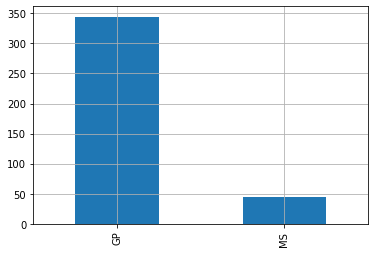

In [14]:
rate_obj['school'].value_counts().plot(kind='bar', grid=True)

В датасете представлены данные по ученикам двух школ, причём, как видно из графика, распределение не равномерное с сильным перекосом в сторону школы GP. По этой причине данный параметр для будущей модели не подходит.

In [15]:
rate = rate.drop('school', axis = 1)

In [16]:
del_list.append('school')

**sex** - пол ученика, принимает два значения: F - женский и M - мужской

0

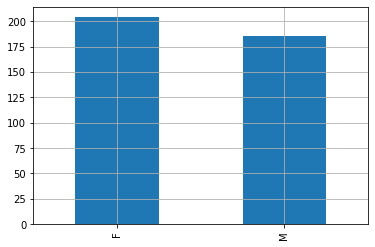

In [17]:
rate_obj['sex'].value_counts().plot(kind='bar', grid=True)
null_data['sex']

Данные по полу распределены равномерно, пропусков нет.

**address** - тип адреса ученика, принимает два значения: U - городской и R - за городом

<AxesSubplot:>

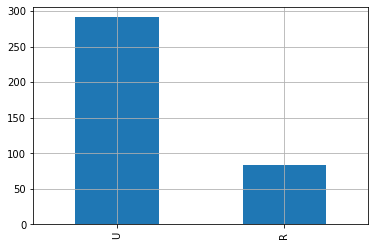

In [18]:
rate_obj['address'].value_counts().plot(kind='bar', grid=True)

Как и в случае со школой распределение смещено. В городе проживает значительно больше учеников чем вне городской черты, данный параметр также не подходит.

In [19]:
rate = rate.drop('address', axis = 1)

In [20]:
del_list.append('address')

**famsize** - размер семьи, принимает два значения: LE3 <= 3, GT3 > 3

GT3    255
LE3    107
Name: famsize, dtype: int64

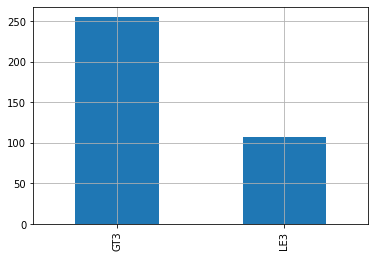

In [21]:
rate_obj['famsize'].value_counts().plot(kind='bar', grid=True)
display(rate_obj['famsize'].value_counts())

Распределение также неравномерное, разница между значениями превышает 50%, не подходит.

In [22]:
rate = rate.drop('famsize', axis = 1)

In [23]:
del_list.append('famsize')

**pstatus** - статус совместного жилья родителей: T - живут вместе, A - живут раздельно

<AxesSubplot:>

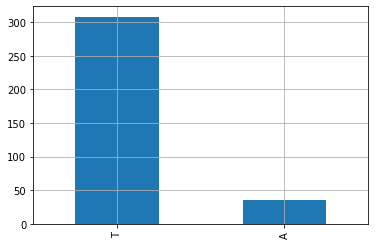

In [24]:
rate_obj['pstatus'].value_counts().plot(kind='bar', grid=True)

Данные распределены неравномерно - не подходит

In [25]:
rate = rate.drop('pstatus', axis = 1)

In [26]:
del_list.append('pstatus')

**mjob** - работа метери:  teacher - учитель, health - сфера здравоохранения, services - гос служба, at_home - не работает, other - другое

<AxesSubplot:>

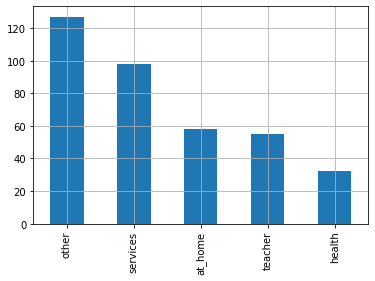

In [27]:
rate_obj['mjob'].value_counts().plot(kind='bar', grid=True)

Данные распределены неравномерно, но данный параметр может пригодиться в будущем.

**fjob** - работа отца:  teacher - учитель, health - сфера здравоохранения, services - гос служба, at_home - не работает, other - другое

<AxesSubplot:>

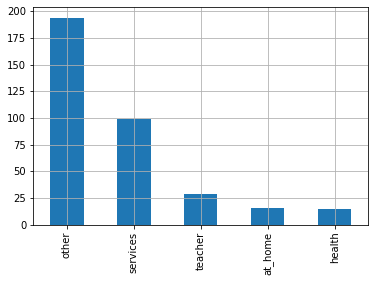

In [28]:
rate_obj['fjob'].value_counts().plot(kind='bar', grid=True)

Аналогично предыдущему, хотя неравномерность выражена сильнее.

**reason** - причина выбора школы: home - близость к дому, reputation - репутация школы, course - образовательная программа, other - другое

<AxesSubplot:>

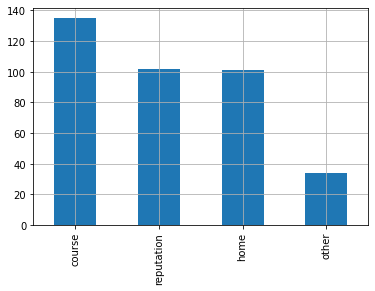

In [29]:
rate_obj['reason'].value_counts().plot(kind='bar', grid=True)

Между тремя основными параметрами данные распределены примерно равномерно, оставляем.

**guardian** - опекун: mother - мать, father - отец, other - другое

mother    248
father     86
other      24
Name: guardian, dtype: int64

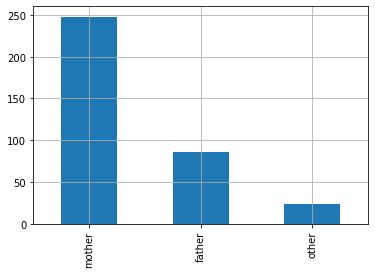

In [30]:
rate_obj['guardian'].value_counts().plot(kind='bar', grid=True)
rate_obj['guardian'].value_counts()

Распределение неравномерное. Можно объединить параметры father и other, чтобы посмотреть, что из этого получится.
Для этого создадим новый параметр guardian_mother, который будет принимать значения yes и no.

In [31]:
rate['guardian_mother'] = np.where(rate['guardian'] == 'mother', 'yes', 'no')

Посмотрим на распределение нового параметра.

<AxesSubplot:>

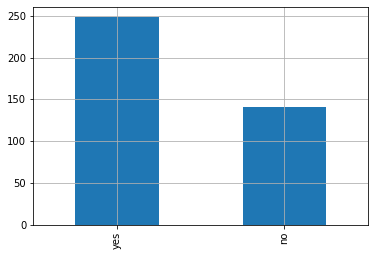

In [32]:
rate['guardian_mother'].value_counts().plot(kind='bar', grid=True)

Сам же параметр удалим.

In [33]:
rate = rate.drop('guardian', axis = 1)

In [34]:
del_list.append('guardian')

Разница между значениями параметров превышает 50%, оставляем для дальнейшего анализа.

**schoolsup** - дополнительная образовательная поддержка

<AxesSubplot:>

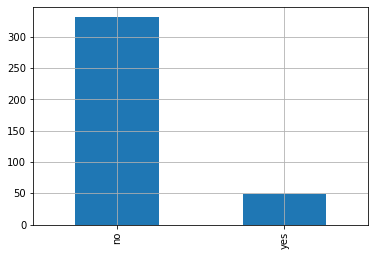

In [35]:
rate_obj['schoolsup'].value_counts().plot(kind='bar', grid=True)

Сам по себе параметр интересный, но разница между значениями очень большая, не подходит.

In [36]:
rate = rate.drop('schoolsup', axis = 1)

In [37]:
del_list.append('schoolsup')

**famsup** - семейная образовательная поддержка

<AxesSubplot:>

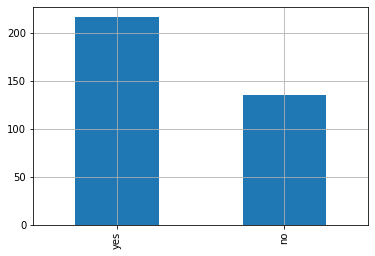

In [38]:
rate_obj['famsup'].value_counts().plot(kind='bar', grid=True)

А этот параметр уже оставляем - распределение смещено не так сильно.

**paid** - дополнительные платные занятия по математике

<AxesSubplot:>

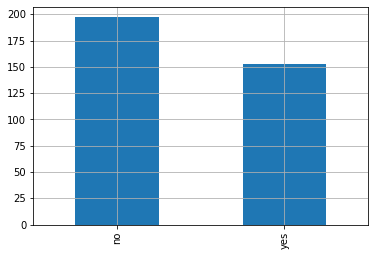

In [39]:
rate_obj['paid'].value_counts().plot(kind='bar', grid=True)

В данном случае распределение почти равномерное, оставляем.

**activities** - дополнительные внеучебные занятия

<AxesSubplot:>

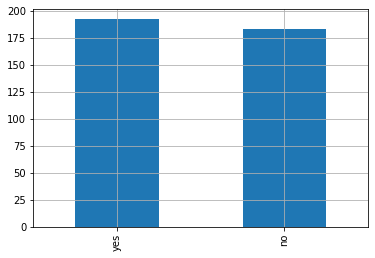

In [40]:
rate_obj['activities'].value_counts().plot(kind='bar', grid=True)

Данные распределены равномерно, оставляем.

**nursery** - посещал детский сад

<AxesSubplot:>

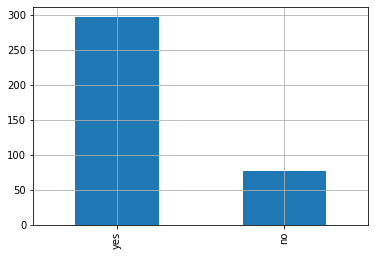

In [41]:
rate_obj['nursery'].value_counts().plot(kind='bar', grid=True)

Снова неравномерное распределение с сильным перекосом, исключаем.

In [42]:
rate = rate.drop('nursery', axis = 1)

In [43]:
del_list.append('nursery')

**higher** - хочет получить высшее образование

<AxesSubplot:>

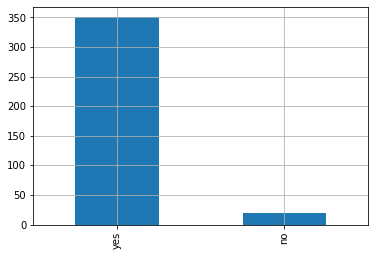

In [44]:
rate_obj['higher'].value_counts().plot(kind='bar', grid=True)

Неравномерное распределение, исключаем

In [45]:
rate = rate.drop('higher', axis = 1)

In [46]:
del_list.append('higher')

**internet** - наличие интернета дома

<AxesSubplot:>

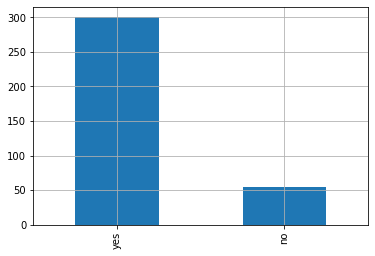

In [47]:
rate_obj['internet'].value_counts().plot(kind='bar', grid=True)

Неравномерное распределение, исключаем

In [48]:
rate = rate.drop('internet', axis = 1)

In [49]:
del_list.append('internet')

**romantic** - в романтических отношениях

<AxesSubplot:>

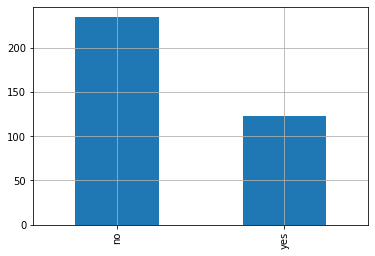

In [50]:
rate_obj['romantic'].value_counts().plot(kind='bar', grid=True)

Распределение смещено, разница порядка 50%, можно оставить.

In [51]:
print(del_list)

['school', 'address', 'famsize', 'pstatus', 'guardian', 'schoolsup', 'nursery', 'higher', 'internet']


В итоге исключаем из датасета по причине сильно смещённого распределения следующие параметры: 'school', 'address', 'famsize', 'pstatus', 'schoolsup', 'nursery', 'higher', 'internet', исключаем 'guardian', вместо него используем 'guardian_mother'. Эти параметры могут вносить определённый вклад в формирование итоговой оценки за тест по математике, но на примере имеющегося датасета правильно учесть его не получится, данных не достаточно.
Сформируем довый датафрейм с оставшимися параметрами.

In [52]:
rate_for_model = rate.copy()
display(rate_for_model.head())

,sex,age,medu,fedu,mjob,fjob,reason,traveltime,studytime,failures,famsup,paid,activities,studytime_granular,romantic,famrel,freetime,goout,health,absences,score,guardian_mother
0,F,18,4.0,4.0,at_home,teacher,course,2.0,2.0,0.0,no,no,no,-6.0,no,4.0,3.0,4.0,3.0,6.0,30.0,yes
1,F,17,1.0,1.0,at_home,other,course,1.0,2.0,0.0,yes,no,no,-6.0,no,5.0,3.0,3.0,3.0,4.0,30.0,no
2,F,15,1.0,1.0,at_home,other,other,1.0,2.0,3.0,no,NaN,no,-6.0,NaN,4.0,3.0,2.0,3.0,10.0,50.0,yes
3,F,15,4.0,2.0,health,NaN,home,1.0,3.0,0.0,yes,yes,yes,-9.0,yes,3.0,2.0,2.0,5.0,2.0,75.0,yes
4,F,16,3.0,3.0,other,other,home,1.0,2.0,0.0,yes,yes,no,-6.0,no,4.0,3.0,2.0,5.0,4.0,50.0,no


Оставшиеся параметры имеют числовой тип: int64 и float64
Рассмотрим их подробнее для заполнеия пропусков и оценки количества выбросов

In [53]:
rate_num = rate.select_dtypes(include=['float64', 'int64']).copy()
rate_num.head()

,age,medu,fedu,traveltime,studytime,failures,studytime_granular,famrel,freetime,goout,health,absences,score
0,18,4.0,4.0,2.0,2.0,0.0,-6.0,4.0,3.0,4.0,3.0,6.0,30.0
1,17,1.0,1.0,1.0,2.0,0.0,-6.0,5.0,3.0,3.0,3.0,4.0,30.0
2,15,1.0,1.0,1.0,2.0,3.0,-6.0,4.0,3.0,2.0,3.0,10.0,50.0
3,15,4.0,2.0,1.0,3.0,0.0,-9.0,3.0,2.0,2.0,5.0,2.0,75.0
4,16,3.0,3.0,1.0,2.0,0.0,-6.0,4.0,3.0,2.0,5.0,4.0,50.0


**age** - возраст ученика, принимает значения от 15 до 22

count    389.000000
mean      16.673522
std        1.265662
min       15.000000
25%       16.000000
50%       17.000000
75%       18.000000
max       22.000000
Name: age, dtype: float64

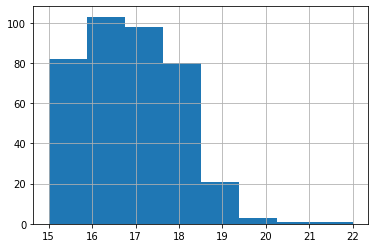

In [54]:
rate_num['age'].hist(bins=8)
rate_num['age'].describe()

Как можно видеть, все значения укладываются в заданный диапазон, выбросов нет.

**medu** - образование матери, принимает пять значения от 0 до 4

count    386.000000
mean       2.766839
std        1.094277
min        0.000000
25%        2.000000
50%        3.000000
75%        4.000000
max        4.000000
Name: medu, dtype: float64

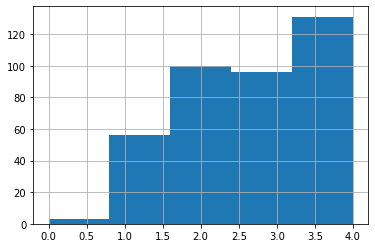

In [55]:
rate_num['medu'].hist(bins=5)
rate_num['medu'].describe()

Как можно видеть все значения укладываются в заданный интервал.
В данном случае значения носят категориальный характер, поэтому для заполнения пропусков можно использовать моду.

**fedu** - образование отца, принимает пять значения от 0 до 4

count    365.000000
mean       2.627397
std        2.241790
min        0.000000
25%        2.000000
50%        3.000000
75%        3.000000
max       40.000000
Name: fedu, dtype: float64

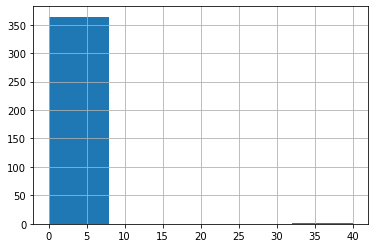

In [56]:
rate_num['fedu'].hist(bins=5)
rate_num['fedu'].describe()

Сдесь всё аналогично признаку medu, с той лишь разницей, что в данном случае имеется один выброс со значением 40. Вероятно это опечатка, поэтому заменим 40 на 4.

In [57]:
rate['fedu'] = rate['fedu'].replace(40, 4)

count    365.000000
mean       2.528767
std        1.088082
min        0.000000
25%        2.000000
50%        3.000000
75%        3.000000
max        4.000000
Name: fedu, dtype: float64

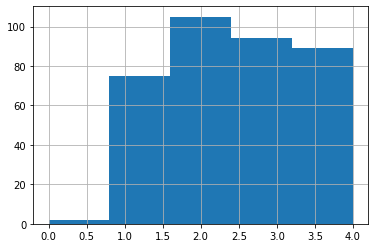

In [58]:
rate['fedu'].hist(bins=5)
rate['fedu'].describe()

Сразу объединим столбцы образования отца и матери (fedu и medu) в столбец образование родителей - pedu, а сами колонки удалим.

**pedu** - обзование родителей, как сумма образований матери и отца, чем выше показатель, тем лучше образование.

In [59]:
rate['pedu'] = rate['medu'] + rate['fedu']
rate = rate.drop(['medu', 'fedu'], axis = 1)

In [60]:
del_list.append('medu')
del_list.append('fedu')

count    362.00000
mean       5.28453
std        1.96767
min        1.00000
25%        4.00000
50%        5.00000
75%        7.00000
max        8.00000
Name: pedu, dtype: float64

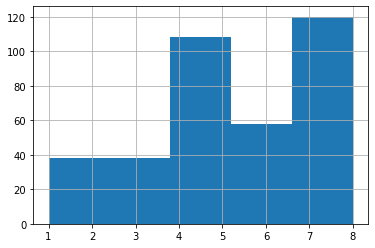

In [61]:
rate['pedu'].hist(bins=5)
rate['pedu'].describe()

**traveltime** - время пути до школы, принимает четыре значения от 1 до 4.

count    361.000000
mean       1.434903
std        0.692660
min        1.000000
25%        1.000000
50%        1.000000
75%        2.000000
max        4.000000
Name: traveltime, dtype: float64

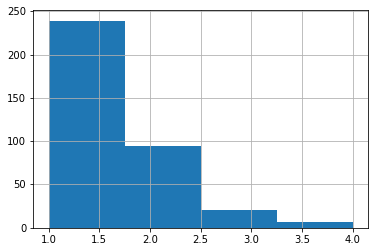

In [62]:
rate_num['traveltime'].hist(bins=4)
rate_num['traveltime'].describe()

Выбросов нет, пропуски также заолним модой.

**studytime** - время на учёбу помимо школы в неделю, принимает четыре значения от 1 до 4.

count    382.000000
mean       2.036649
std        0.847239
min        1.000000
25%        1.000000
50%        2.000000
75%        2.000000
max        4.000000
Name: studytime, dtype: float64

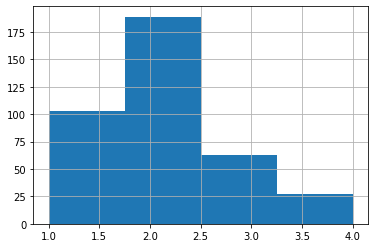

In [63]:
rate_num['studytime'].hist(bins=4)
rate_num['studytime'].describe()

Аналогично заменяем пропуски модой, выбросов нет.

**failures** - количество внеучебных неудач, принимает четыре значения от 0 до 3.

count    367.000000
mean       0.326975
std        0.729479
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        3.000000
Name: failures, dtype: float64

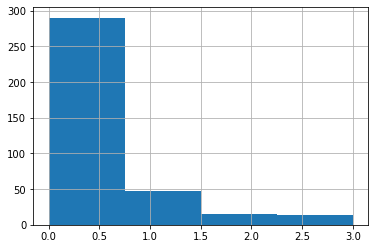

In [64]:
rate_num['failures'].hist(bins=4)
rate_num['failures'].describe()

Можно объединить признаки со значениями 1, 2 и 3 в один: 0 - нет неудач, 1 - есть неудачи

In [65]:
rate['failures'] = np.where(rate['failures'].isin([1, 2, 3]), 1, 0)

<AxesSubplot:>

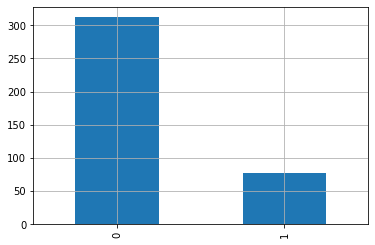

In [66]:
rate['failures'].value_counts().plot(kind='bar', grid=True)

Вот только из-за того, что распределение данных сильно смещено в сторону отсутствия неудач, данный параметр не подходит для использования в модели.

In [67]:
rate = rate.drop('failures', axis = 1)

In [68]:
del_list.append('failures')

**studytime_granular** - неизвестный параметр, посмотрим его распределение

count    382.000000
mean      -6.109948
std        2.541716
min      -12.000000
25%       -6.000000
50%       -6.000000
75%       -3.000000
max       -3.000000
Name: studytime_granular, dtype: float64

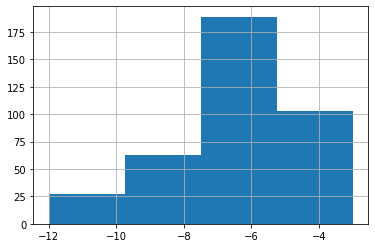

In [69]:
rate_num['studytime_granular'].hist(bins=4)
rate_num['studytime_granular'].describe()

Видно, что распределение параметра полностью совпадает с колонкой studytime, только в зеркальном отображении, количество пропущенных значений такое же. Для лучшего сравнения определим коэффициент взаимной корреляции этих столбцов.

In [70]:
rate_num['studytime'].corr(rate_num['studytime_granular'])

-0.9999999999999993

Коэффициент корреляции равен -1, что говорит о полной идентичности данных, следовательно, один из столбцов можно удалить. Также очевидно, что studytime_granular = studytime * -3

In [71]:
rate = rate.drop('studytime_granular', axis = 1)

In [72]:
del_list.append('studytime_granular')

Этим столбцом будет studytime_granular

**famrel** - семейные отношения, принимает пять значения от 1 до 5

count    362.000000
mean       3.930939
std        0.931554
min       -1.000000
25%        4.000000
50%        4.000000
75%        5.000000
max        5.000000
Name: famrel, dtype: float64

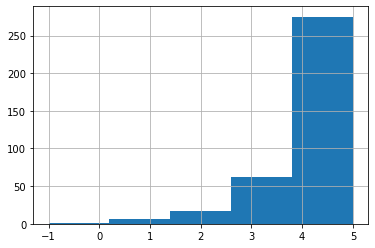

In [73]:
rate_num['famrel'].hist(bins=5)
rate_num['famrel'].describe()

Есть один выброс - -1, здесь, скорее всего, просто лишний минус, поэтому заменим его на 1

In [74]:
rate['famrel'] = rate['famrel'].replace(-1, 1)

count    362.000000
mean       3.936464
std        0.907858
min        1.000000
25%        4.000000
50%        4.000000
75%        5.000000
max        5.000000
Name: famrel, dtype: float64

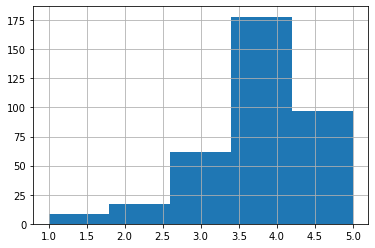

In [75]:
rate['famrel'].hist(bins=5)
rate['famrel'].describe()

**freetime** - свободное время после школы, принимает пять значения от 1 до 5

count    380.000000
mean       3.223684
std        0.993364
min        1.000000
25%        3.000000
50%        3.000000
75%        4.000000
max        5.000000
Name: freetime, dtype: float64

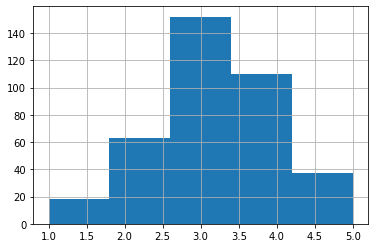

In [76]:
rate_num['freetime'].hist(bins=5)
rate_num['freetime'].describe()

Выбросов нет, распределение близко к нормальному

**goout** - проведение времни с друзьями, принимает пять значения от 1 до 5

count    382.000000
mean       3.094241
std        1.116104
min        1.000000
25%        2.000000
50%        3.000000
75%        4.000000
max        5.000000
Name: goout, dtype: float64

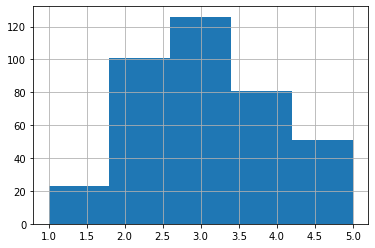

In [77]:
rate_num['goout'].hist(bins=5)
rate_num['goout'].describe()

Выбросов нет, распределение близко к нормальному

**health** - текущее состояние здоровья, принимает пять значения от 1 до 5

count    374.000000
mean       3.529412
std        1.402006
min        1.000000
25%        3.000000
50%        4.000000
75%        5.000000
max        5.000000
Name: health, dtype: float64

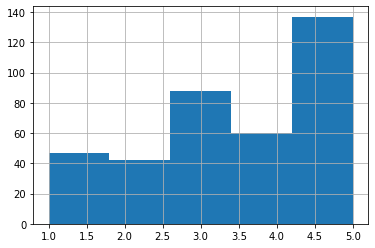

In [78]:
rate_num['health'].hist(bins=5)
rate_num['health'].describe()

Выбросов нет

**absences** - количество пропущенных занятий, нет известного диапазона значений

In [79]:
rate_num['absences'].value_counts()

0.0      110
2.0       60
4.0       52
6.0       30
8.0       20
10.0      17
14.0      12
12.0      12
16.0       7
3.0        7
7.0        6
18.0       5
5.0        5
20.0       4
9.0        3
22.0       3
1.0        3
13.0       2
15.0       2
11.0       2
40.0       1
38.0       1
56.0       1
23.0       1
24.0       1
25.0       1
385.0      1
17.0       1
75.0       1
21.0       1
212.0      1
28.0       1
19.0       1
26.0       1
30.0       1
54.0       1
Name: absences, dtype: int64

count    378.000000
mean       7.320106
std       23.615525
min        0.000000
25%        0.000000
50%        4.000000
75%        8.000000
max      385.000000
Name: absences, dtype: float64

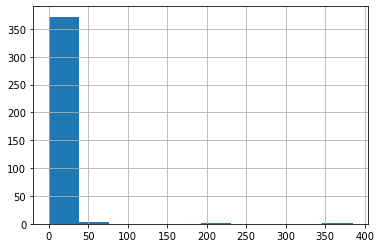

In [80]:
rate_num['absences'].hist()
rate_num['absences'].describe()

Видно, что наибольшее число пропусков лежит в интервале 0-8, при стандартном отклонении 24. Максимальное значение 385 кажется более чем странным.
Попробуем отсеить выбросы методом межквартильного интервала.

25-й перцентиль: 0.0, 75-й перцентиль: 8.0, IQR: 8.0 Границы выбросов: 0.0, 20.0


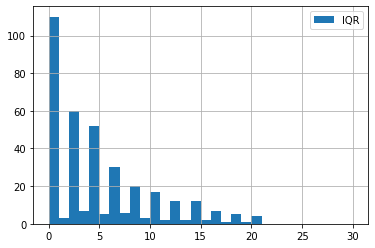

In [81]:
IQR = rate_num['absences'].quantile(0.75) - rate_num['absences'].quantile(0.25)
perc25 = rate_num['absences'].quantile(0.25)
perc75 = rate_num['absences'].quantile(0.75)
print(f'25-й перцентиль: {perc25}, 75-й перцентиль: {perc75}, IQR: {IQR}',
      f'Границы выбросов: {perc25}, {perc75 + IQR*1.5}')
rate_num['absences'].loc[
    rate_num['absences'].between(perc25, perc75 + 1.5*IQR)
].hist(bins=30, range=(0, 30), label='IQR')
plt.legend()

Таким образом за выбросы считаются все значения больше 20.
Построим также boxplot

<AxesSubplot:xlabel='absences'>

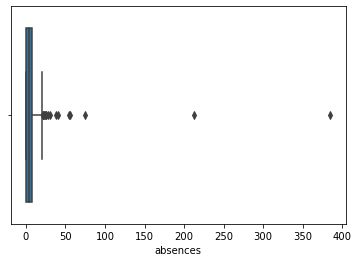

In [82]:
sns.boxplot(data = rate_num, x = 'absences')

Вероятно считать за выбросы все значения выше 20 всё же не стоит. Хотя в исходных данных и не указано к какому промежутку времени относятся пропуски занятий: за год или за свё время учёбы. Поэтому, чтобы сильно не сокращать и так не большой датасет, выбросами будем считать значения пропусков больше 50. Удалим эти строки, т.к. логично предположить, что если ученик пропустил такое количество занятий, сколько-нибудь высокий балл по математике он не получит и таких значений в датасете всего 5.

In [83]:
rate = rate[rate['absences'] < 50]

<AxesSubplot:xlabel='absences'>

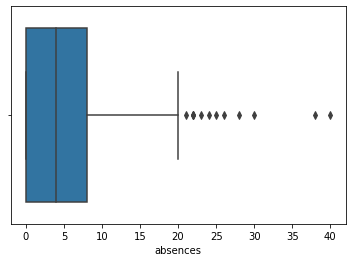

In [84]:
sns.boxplot(data = rate, x = 'absences')

В итоге из числовых параметров были удалены следующие столюцы: 'medu', 'fedu', 'failures', 'studytime_granular', добавлена одна оюъединённая колонка - 'pedu' и удалено 5 срок.

In [85]:
print(del_list)

['school', 'address', 'famsize', 'pstatus', 'guardian', 'schoolsup', 'nursery', 'higher', 'internet', 'medu', 'fedu', 'failures', 'studytime_granular']


В нашем случае получается, что для заполнения пропусков во всех данных можно использовать моду по каждому из параметров, т.к. все они носят скорее категориальный, а не числовой хорактер.

In [86]:
plus_data = rate.copy()           
plus_data = add_data(rate)
display(plus_data.head())

,sex,age,mjob,fjob,reason,traveltime,studytime,famsup,paid,activities,romantic,famrel,freetime,goout,health,absences,score,guardian_mother,pedu
0,F,18,at_home,teacher,course,2.0,2.0,no,no,no,no,4.0,3.0,4.0,3.0,6.0,30.0,yes,8.0
1,F,17,at_home,other,course,1.0,2.0,yes,no,no,no,5.0,3.0,3.0,3.0,4.0,30.0,no,2.0
2,F,15,at_home,other,other,1.0,2.0,no,no,no,no,4.0,3.0,2.0,3.0,10.0,50.0,yes,2.0
3,F,15,health,other,home,1.0,3.0,yes,yes,yes,yes,3.0,2.0,2.0,5.0,2.0,75.0,yes,6.0
4,F,16,other,other,home,1.0,2.0,yes,yes,no,no,4.0,3.0,2.0,5.0,4.0,50.0,no,6.0


Проверим, что заполнили все пропуски

In [87]:
null_data = plus_data.isnull().sum()
null_data[null_data > 0]

Series([], dtype: int64)

In [88]:
print(len(del_list))

13


Таким образом, по итогу из исходного датасета были удалены 11 срок и 13 колонок, добавлена одна объединённая и одна колонка заменена.
Выбросов и пропусков данных было не много.

**Корреляционный анализ**

Выясним, какие столбцы коррелируют с оценкой за тест по математике. Это поможет понять, какие параметры стоит оставить для модели, а какие — исключить. 

Корреляции рассмотрим только для числовых столбцов.

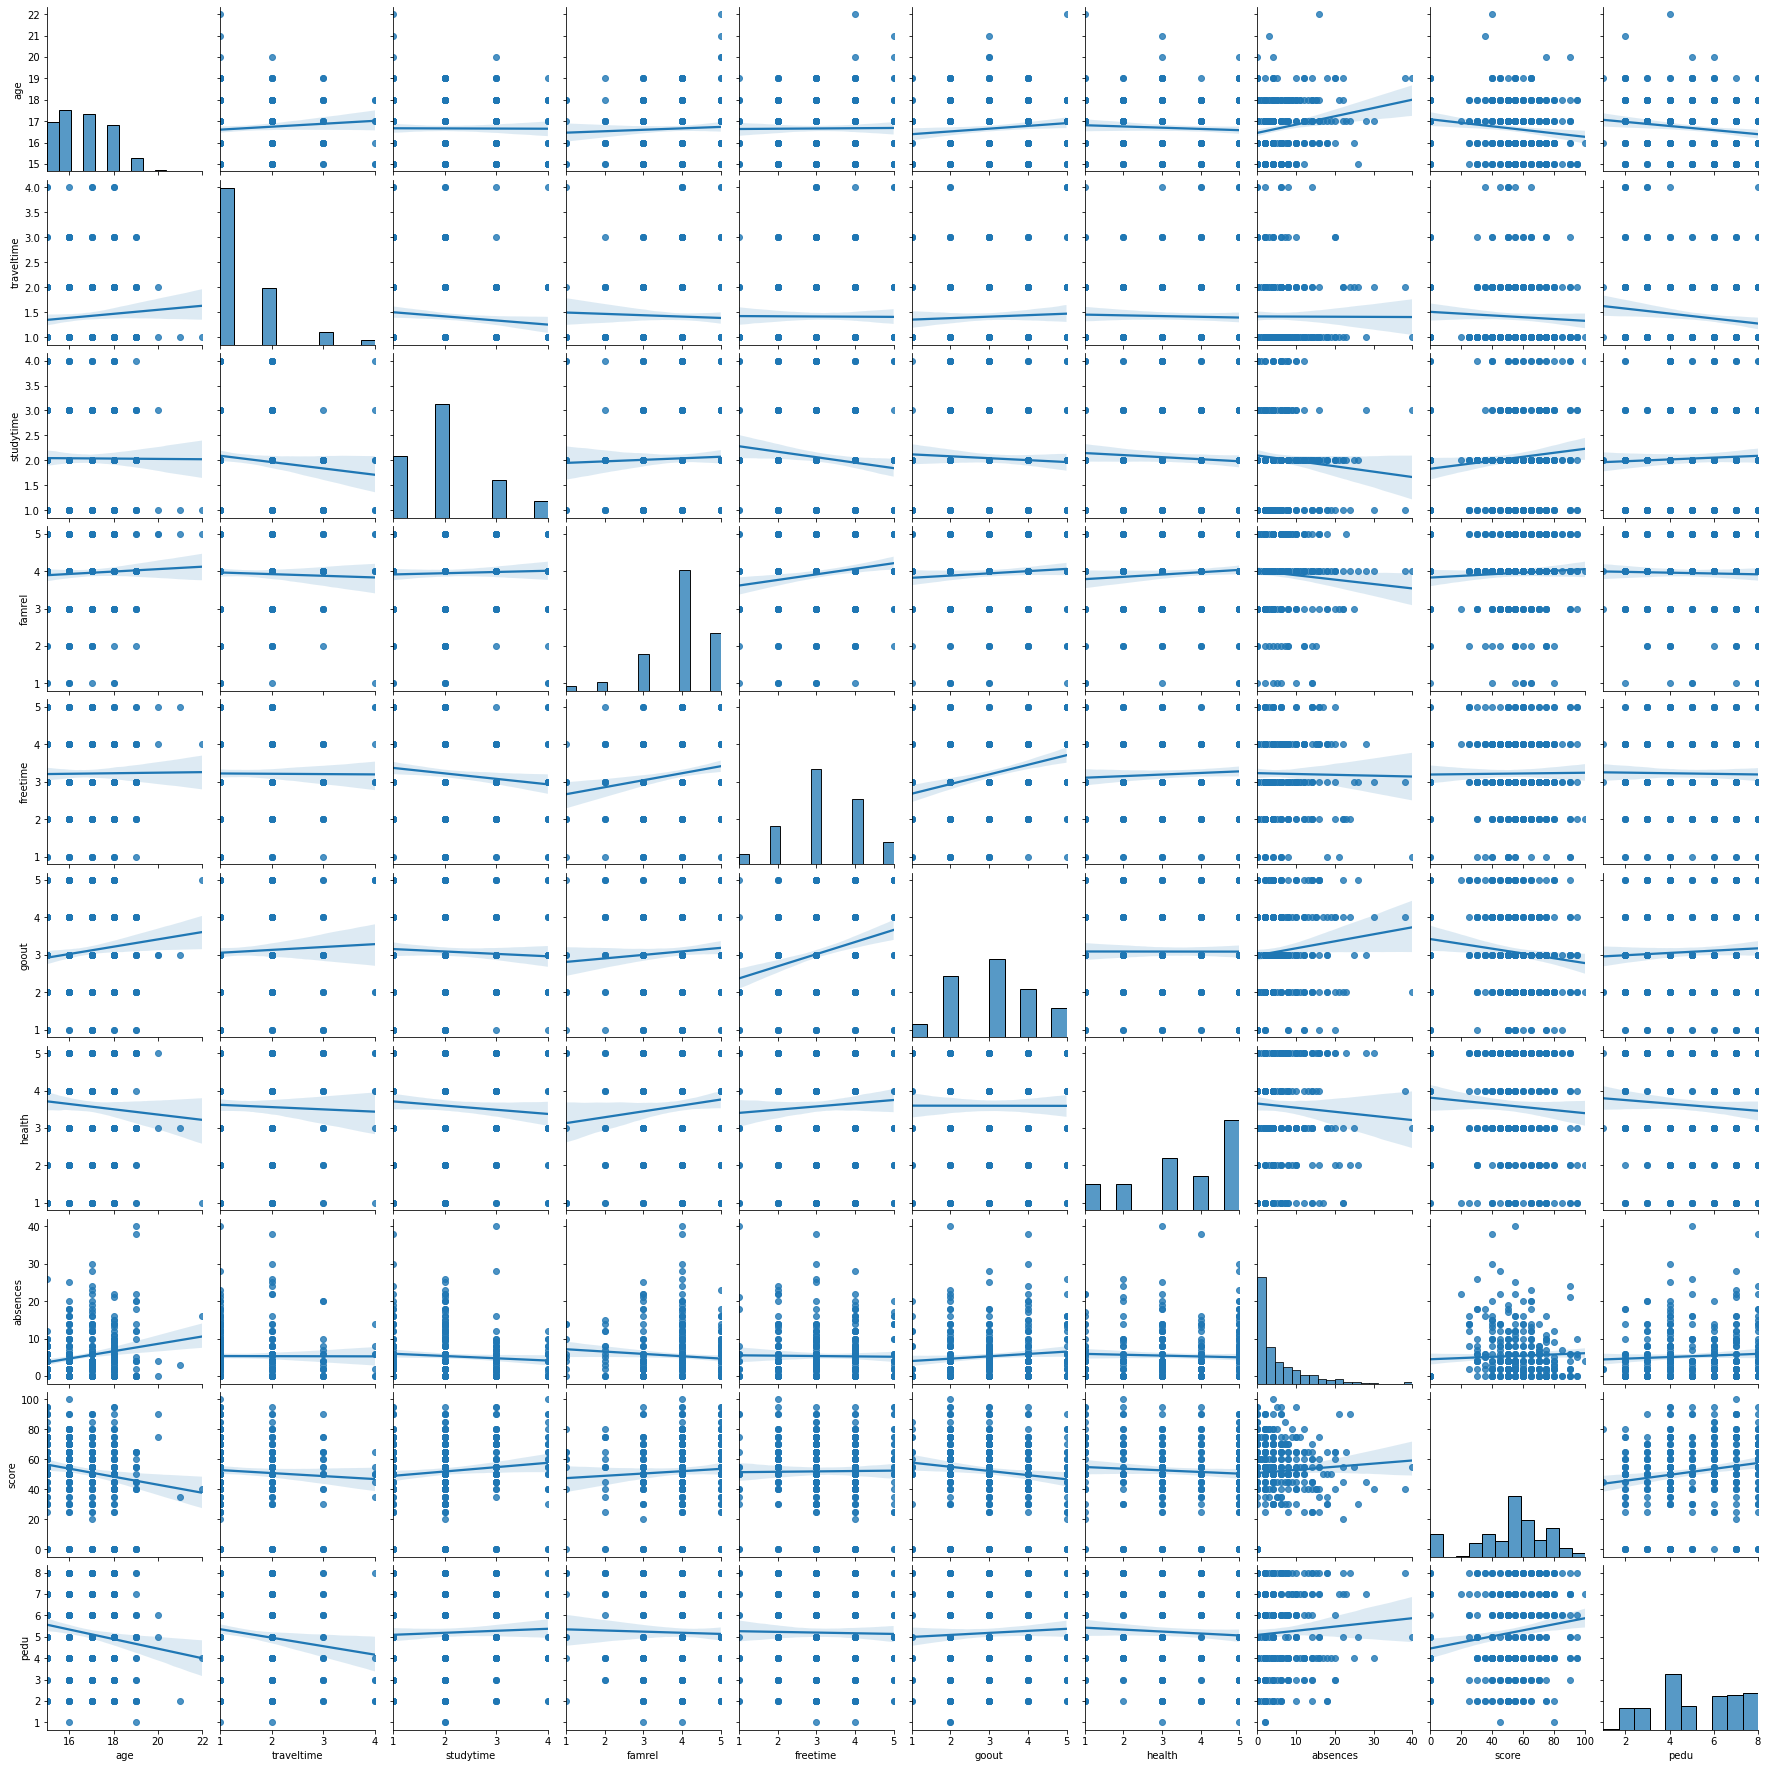

In [89]:
sns.pairplot(plus_data, kind = 'reg')

Посмотрим также на тепловую карту распределения коэффициента корреляции

<AxesSubplot:>

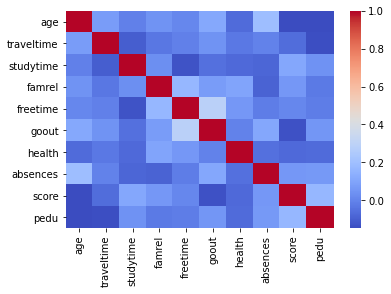

In [92]:
correll = plus_data.corr()
sns.heatmap(correll, annot = False, cmap = 'coolwarm')

Выясним, какие столбцы коррелируют с оценкой, полученной за тест по математике. Это поможет понять, какие параметры стоит оставить для модели, а какие — исключить. 

In [94]:
correll

,age,traveltime,studytime,famrel,freetime,goout,health,absences,score,pedu
age,1.000000,0.074539,-0.004835,0.046721,0.009455,0.112323,-0.063898,0.194972,-0.148292,-0.146343
traveltime,0.074539,1.000000,-0.102573,-0.034732,-0.005777,0.047738,-0.029950,-0.002801,-0.060002,-0.140899
studytime,-0.004835,-0.102573,1.000000,0.031837,-0.126750,-0.049853,-0.067804,-0.080893,0.107880,0.041205
famrel,0.046721,-0.034732,0.031837,1.000000,0.167158,0.074753,0.098738,-0.085619,0.059105,-0.024164
freetime,0.009455,-0.005777,-0.126750,0.167158,1.000000,0.288806,0.060452,-0.014663,0.011045,-0.016214
goout,0.112323,0.047738,-0.049853,0.074753,0.288806,1.000000,-0.001121,0.108336,-0.133678,0.054058
health,-0.063898,-0.029950,-0.067804,0.098738,0.060452,-0.001121,1.000000,-0.050275,-0.067832,-0.066022
absences,0.194972,-0.002801,-0.080893,-0.085619,-0.014663,0.108336,-0.050275,1.000000,0.058081,0.064494
score,-0.148292,-0.060002,0.107880,0.059105,0.011045,-0.133678,-0.067832,0.058081,1.000000,0.167759
pedu,-0.146343,-0.140899,0.041205,-0.024164,-0.016214,0.054058,-0.066022,0.064494,0.167759,1.000000


Как видим значение коэффициента корреляции между оставшимися параметрами не превышает 30%

Оставим параметры со значением корреляции больше 10% по модулю

In [96]:
plus_data.corr()[(plus_data.corr() < -0.1) | (plus_data.corr() > 0.1)]

,age,traveltime,studytime,famrel,freetime,goout,health,absences,score,pedu
age,1.000000,NaN,NaN,NaN,NaN,0.112323,NaN,0.194972,-0.148292,-0.146343
traveltime,NaN,1.000000,-0.102573,NaN,NaN,NaN,NaN,NaN,NaN,-0.140899
studytime,NaN,-0.102573,1.000000,NaN,-0.126750,NaN,NaN,NaN,0.107880,NaN
famrel,NaN,NaN,NaN,1.000000,0.167158,NaN,NaN,NaN,NaN,NaN
freetime,NaN,NaN,-0.126750,0.167158,1.000000,0.288806,NaN,NaN,NaN,NaN
goout,0.112323,NaN,NaN,NaN,0.288806,1.000000,NaN,0.108336,-0.133678,NaN
health,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
absences,0.194972,NaN,NaN,NaN,NaN,0.108336,NaN,1.000000,NaN,NaN
score,-0.148292,NaN,0.107880,NaN,NaN,-0.133678,NaN,NaN,1.000000,0.167759
pedu,-0.146343,-0.140899,NaN,NaN,NaN,NaN,NaN,NaN,0.167759,1.000000


В итоге из числовых параметров для построения модели будут использованы: 'age', 'studytime', 'goout', 'pedu'

**Анализ номинативных переменных**

Номинативные переменные, которые осталось рассмотреть: 'sex', 'mjob', 'fjob', 'reason', 'famsup', 'paid', 'activities', 'romantic', 'guardian_mother'

In [97]:
plus_data.select_dtypes(include=['object']).columns

Index(['sex', 'mjob', 'fjob', 'reason', 'famsup', 'paid', 'activities',
       'romantic', 'guardian_mother'],
      dtype='object')

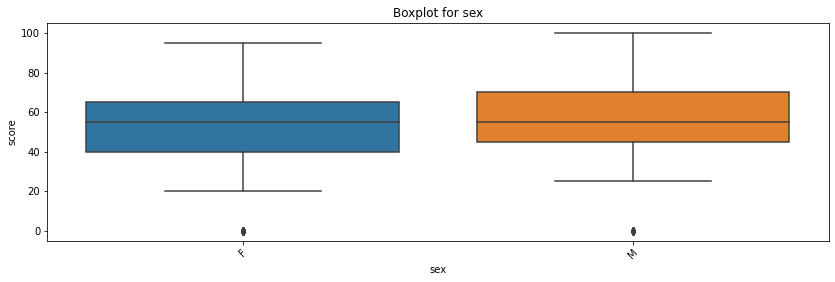

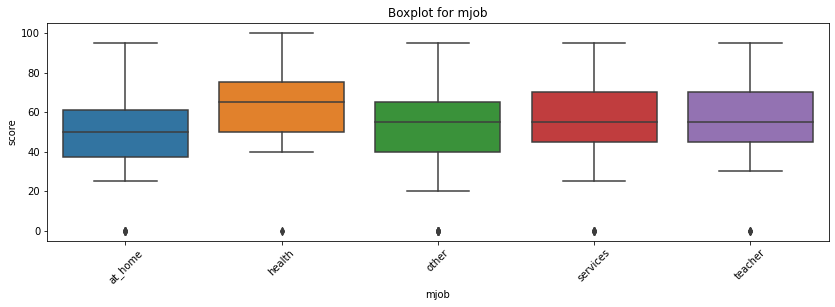

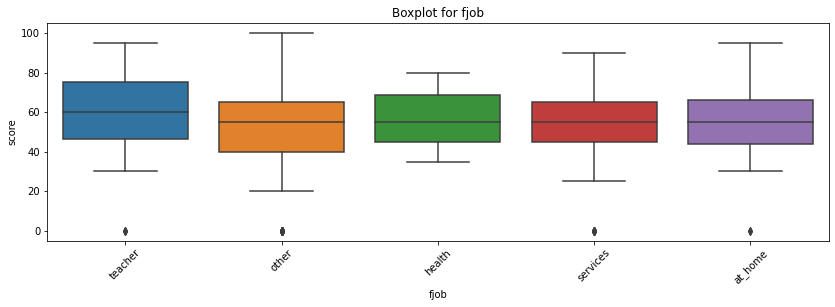

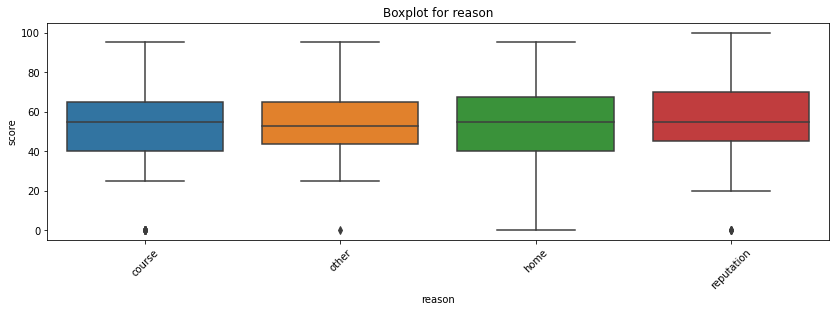

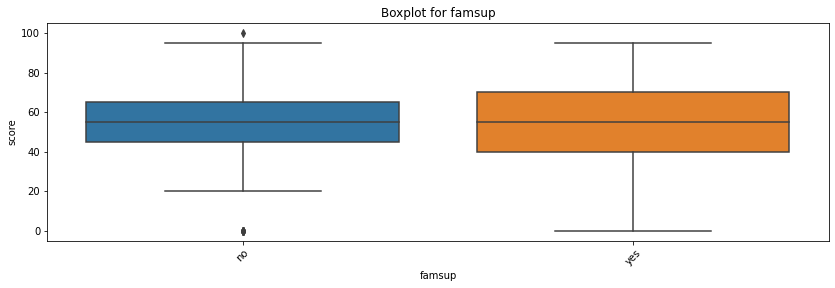

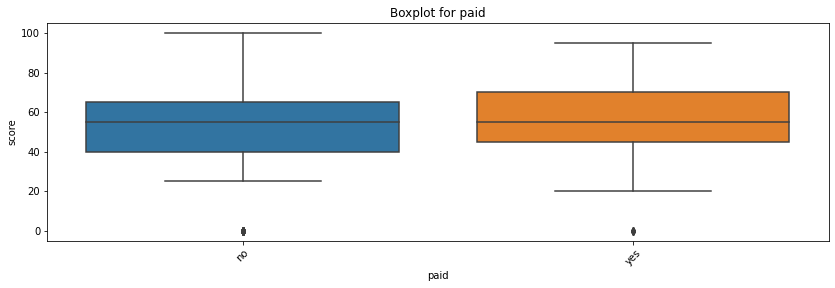

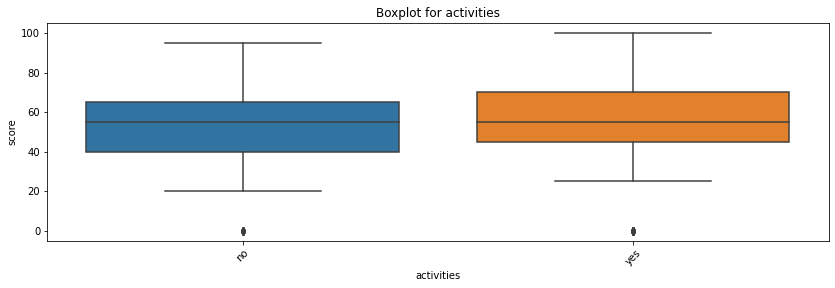

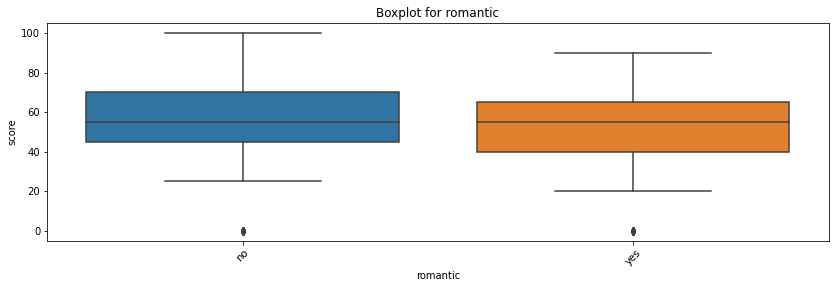

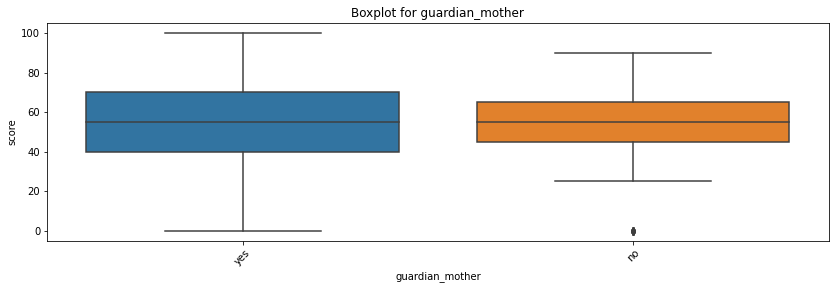

In [99]:
for col in ['sex', 'mjob', 'fjob', 'reason', 'famsup', 'paid', 'activities',
            'romantic', 'guardian_mother']:
    get_boxplot(col)

Проверим, есть ли статистическая разница в распределении оценок по номинативным признакам, с помощью теста Стьюдента. Проверим нулевую гипотезу о том, что распределения оценок за тест по математике не зависит от различных факторов с доверительным интервалом 90%:

In [101]:
for col in ['sex', 'mjob', 'fjob', 'reason', 'famsup', 'paid', 'activities',
            'romantic', 'guardian_mother']:
    get_stat_dif(col)

Найдены статистически значимые различия для колонки sex
Найдены статистически значимые различия для колонки mjob
Найдены статистически значимые различия для колонки paid
Найдены статистически значимые различия для колонки romantic


Как видим, серьёзно отличаются три параметра: 'sex', 'mjob', 'paid' и 'romantic'. Оставим эти переменные в датасете для дальнейшего построения модели. Итак, в нашем случае важные переменные, которые, возможно, оказывают влияние на результат тестирования по математике, это: 'sex', 'mjob', 'paid', 'romantic', 'age', 'studytime', 'goout', 'pedu'.

In [102]:
rate_for_model = plus_data.loc[:, ['sex', 'mjob', 'paid', 'romantic',
                                   'age', 'studytime', 'goout', 'pedu']]
rate_for_model.head()

,sex,mjob,paid,romantic,age,studytime,goout,pedu
0,F,at_home,no,no,18,2.0,4.0,8.0
1,F,at_home,no,no,17,2.0,3.0,2.0
2,F,at_home,no,no,15,2.0,2.0,2.0
3,F,health,yes,yes,15,3.0,2.0,6.0
4,F,other,yes,no,16,2.0,2.0,6.0


Для использования в будущей модели преобзазуем колонки c типом данных object в числовые со значениями 0 и 1.

In [103]:
data_code = rate_for_model.copy()
data_code = code_data(rate_for_model)

Посмотрим как изменились данные

In [104]:
data_code.head()

,age,studytime,goout,pedu,mjob_at_home,mjob_health,mjob_other,mjob_services,mjob_teacher,sex_code,paid_code,romantic_code
0,18,2.0,4.0,8.0,1,0,0,0,0,0,0,0
1,17,2.0,3.0,2.0,1,0,0,0,0,0,0,0
2,15,2.0,2.0,2.0,1,0,0,0,0,0,0,0
3,15,3.0,2.0,6.0,0,1,0,0,0,0,1,1
4,16,2.0,2.0,6.0,0,0,1,0,0,0,1,0


Выводы:

В результате EDA для анализа влияния различных факторов на итоговую оценку за тест по математике были получены следующие выводы:
- В данных достаточно мало пустых значений.
- В силу того, что столбцы с пропущенными значениями имеют категориальный характер, для заполнения пропусков использовалось модальное значение по каждому из параметров.
- По целевому столбцу score строки с пропущенными значениями были удалены из датасета.
- Выбросы найдены только в столбцах содержащих образование отца, сейные отношения и количество пропущенных занатий. Их не много, что позволяет сделать вывод о том, что данные достаточно чистые.
- Самые важные параметры, которые предлагается использовать в дальнейшем для построения модели, это sex, mjob, paid, romantic, age, studytime, goout и pedu.